# Отток клиентов
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import randint, uniform
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [2]:
file_list = [
    "C:\datasc\pracfiles\contract_new.csv",
    "C:\datasc\pracfiles\internet_new.csv",
    "C:\datasc\pracfiles\personal_new.csv",
    "C:\datasc\pracfiles\phone_new.csv"
]

file_list1 = [
    "/datasets/contract_new.csv",
    "/datasets/internet_new.csv",
    "/datasets/personal_new.csv",
    "/datasets/phone_new.csv"
]

In [3]:
if os.path.exists(file_list[0]):
    for i, file_path in enumerate(file_list):
        if os.path.exists(file_path):
            df_name = f'df{i+1}'
            globals()[df_name] = pd.read_csv(file_path)
        else:
            print('something is wrong, check the local file paths')

elif os.path.exists(file_list1[0]):
    for i, file_path in enumerate(file_list1):
        if os.path.exists(file_path):
            df_name = f'df{i+1}'
            globals()[df_name] = pd.read_csv(file_path)
        else:
            print('something is wrong, check the platform file paths')
else:
    print('something is wrong, none of the files work')

In [4]:
display(
    df1.info(),
    df2.info(),
    df3.info(),
    df4.info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-nu

None

None

None

None

Не во всех таблицах количество записей одинаковые, это скорее всего связано с тем, что не все пользователи оформили все варианты контрактов, для облегчения работы можно их смержить в одну по primary key = customerID, также для более плотного анализа требуется привести данные к нужным типам

In [5]:
df = pd.merge(df1, df3, on='customerID', how='left')
df = pd.merge(df, df2, on='customerID', how='left')
df = pd.merge(df, df4, on='customerID', how='left')

In [6]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Поле customerID не несет ценной информации для нас и для моделей будет только мешаться, его можно сразу убрать  
Поле BeginDate нужно привести из типа object в тип datetime  

Из поля Closed стоит сделать таргет, те записи, где стоит какая либо дата можно обозначить как 1 (закрылся договор), там где стоит No, поставить 0 (еще активен), также из этого же поля следует сделать финальную дату тех контрактов, которые закрылись (уже стоит дата), а те, что еще активны поставить дату выгрузки данных (01 февраля 2020г)  

Также стоит сделать фичу, указывающую как долго длился(длится) контракт, для этого из даты финальной вычтем дату начала контракта и приведем в дни    

В данных, где много где отмечено не использование каким либо услугами значением No, поэтому касательно интернета и телефона, записи которые отсутствуют было бы логично заполнить тем же No для каждого пользователя, где стоит пустота

In [8]:
df = df.drop(['customerID'], axis=1)

In [9]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])

In [10]:
df['Closed'] = np.where(df['EndDate'] == 'No', 0, 1)

In [11]:
df = df.fillna('No')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtection  7043 n

In [13]:
df['LastDate'] = np.where(df['EndDate'] == 'No', '2020-02-01', df['EndDate'])
df['LastDate'] = pd.to_datetime(df['LastDate'])

In [14]:
df['ServiceSpan'] = df['LastDate'] - df['BeginDate']
df['ServiceSpan'] = df['ServiceSpan'].dt.days

Видимо строки с пользователями, где в TotalCharges стоит " " еще не заполнены тк пользователи новые, имеет смысл перенести в них нынешние MonthlyCharges  
И привести TotalCharges к численному типу 

In [15]:
display(df.iloc[487:490])
def replace_if_blank(row):
    if row['TotalCharges'] == ' ':
        return row['MonthlyCharges']
    else:
        return row['TotalCharges']

df['TotalCharges'] = df.apply(replace_if_blank, axis=1)
df.iloc[487:490]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Closed,LastDate,ServiceSpan
487,2014-02-01,No,Two year,Yes,Bank transfer (automatic),88.60,6953.33,Male,0,No,...,No,Yes,Yes,Yes,Yes,Yes,Yes,0,2020-02-01,2191
488,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,...,Yes,No,Yes,Yes,Yes,No,No,0,2020-02-01,0
489,2019-09-01,No,Month-to-month,Yes,Electronic check,74.35,382.9,Male,0,No,...,No,No,No,No,No,No,Yes,0,2020-02-01,153


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Closed,LastDate,ServiceSpan
487,2014-02-01,No,Two year,Yes,Bank transfer (automatic),88.60,6953.33,Male,0,No,...,No,Yes,Yes,Yes,Yes,Yes,Yes,0,2020-02-01,2191
488,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55,Female,0,Yes,...,Yes,No,Yes,Yes,Yes,No,No,0,2020-02-01,0
489,2019-09-01,No,Month-to-month,Yes,Electronic check,74.35,382.9,Male,0,No,...,No,No,No,No,No,No,Yes,0,2020-02-01,153


In [16]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges']) 

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtection  7043 n

In [18]:
exclude_columns = ['ServiceSpan', 'LastDate', 'Closed', 'SeniorCitizen', 'BeginDate', 'EndDate', 'MonthlyCharges', 'TotalCharges']
columns = [col for col in df.columns if col not in exclude_columns]

In [19]:
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Closed,LastDate,ServiceSpan
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,No,Yes,No,No,No,No,No,0,2020-02-01,31
1,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,Yes,No,Yes,No,No,No,No,0,2020-02-01,1036
2,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,Yes,Yes,No,No,No,No,No,0,2020-02-01,123
3,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,Yes,No,Yes,Yes,No,No,No,0,2020-02-01,1371
4,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,No,No,No,No,No,No,No,0,2020-02-01,153


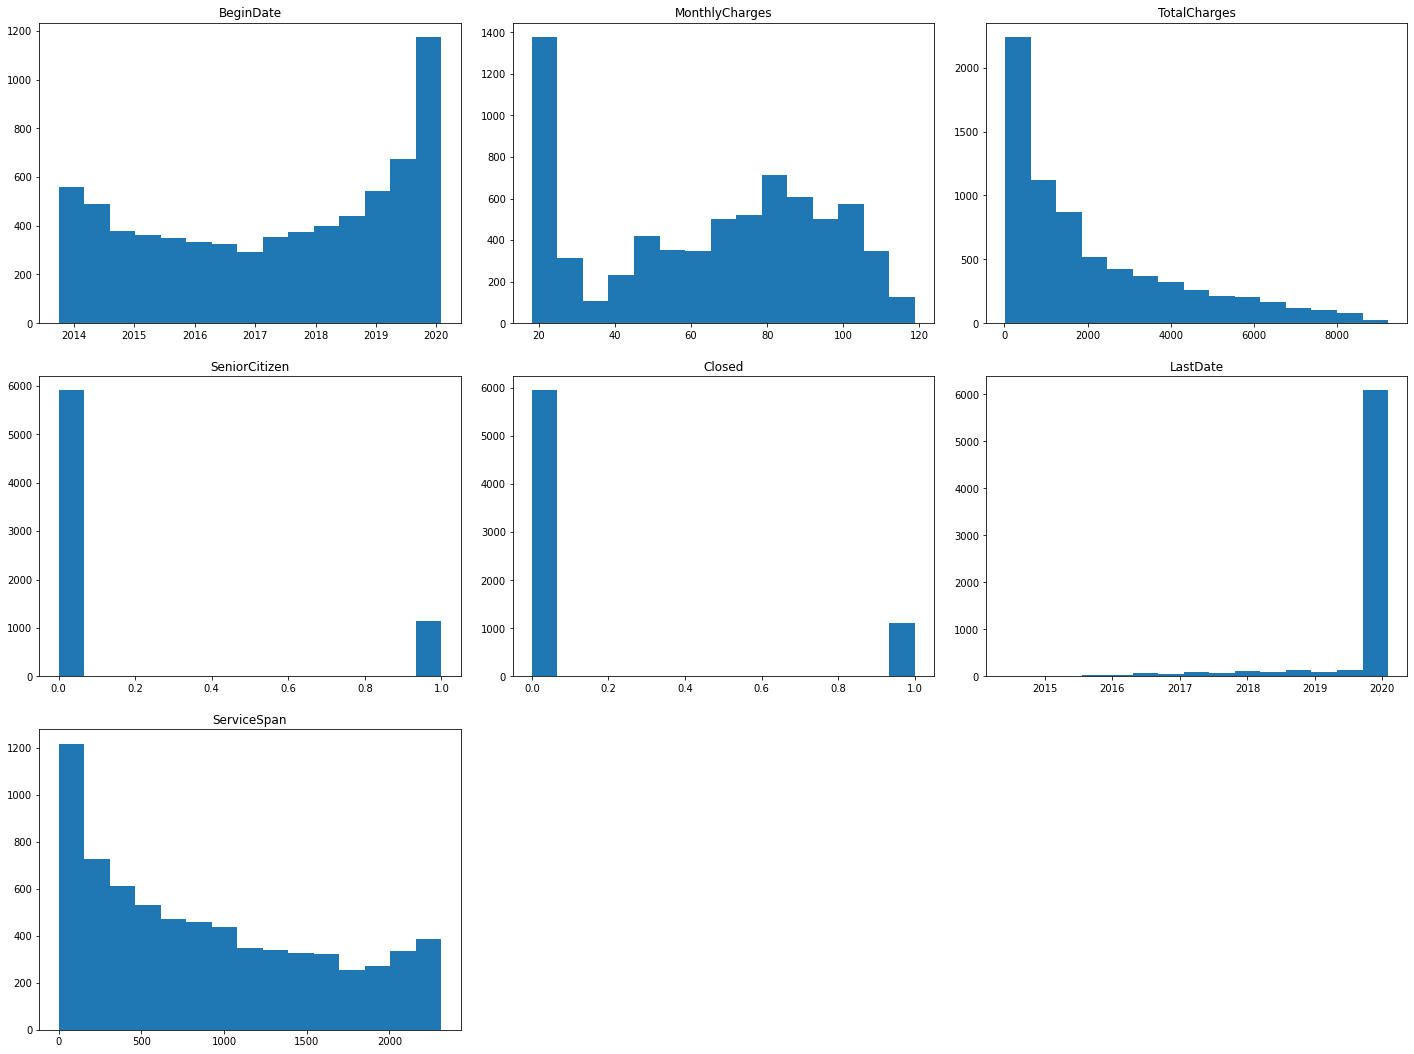

In [20]:
df.hist(bins=15, figsize=(20, 15), grid=False)

plt.tight_layout(pad=2.0)
plt.show()

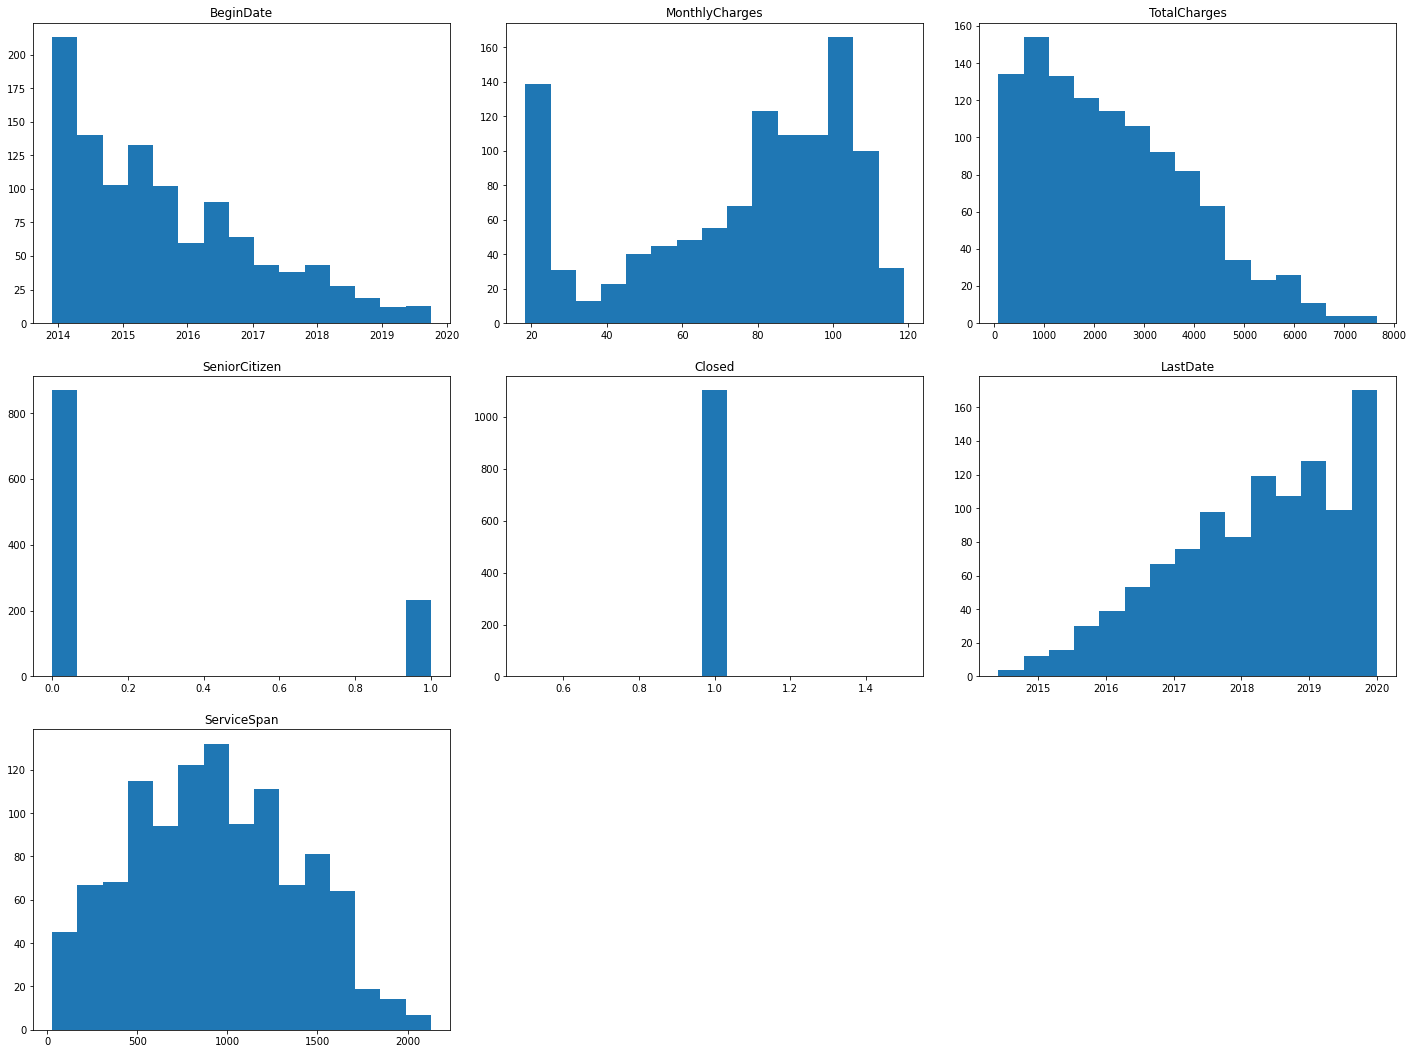

In [21]:
df[df['Closed'] == 1].hist(bins=15, figsize=(20, 15), grid=False)

plt.tight_layout(pad=2.0)
plt.show()

Типичный ушедший клиент отличается от обычного клиента отличается этим:  
-В среднем пользовался сервисом больше (порядка 1000 дней, когда обычный клиент порядка 0-500)  
-Является клиентом уже несколько лет, когда обычные клиенты подключились недавно (видимо недавно была большая рекламная кампания)  
-В месяц и тотально тратит больше денег, чем оставшиеся клиенты

In [22]:
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Closed,LastDate,ServiceSpan
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,No,Yes,No,No,No,No,No,0,2020-02-01,31
1,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,Yes,No,Yes,No,No,No,No,0,2020-02-01,1036
2,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,Yes,Yes,No,No,No,No,No,0,2020-02-01,123
3,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,Yes,No,Yes,Yes,No,No,No,0,2020-02-01,1371
4,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,No,No,No,No,No,No,No,0,2020-02-01,153


## Подготовка к моделированию

In [23]:
features = df.drop(['Closed', 'BeginDate', 'EndDate', 'LastDate'], axis=1)
target = df['Closed']

In [24]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=20824, stratify=target)
print(features_train.shape)
print(target_test.shape)

(5282, 18)
(1761,)


In [25]:
transformer = OneHotEncoder(handle_unknown='ignore')

transformed_train = transformer.fit_transform(features_train)
transformed_test = transformer.transform(features_test)
transformed_train_dense = transformed_train.toarray()
transformed_test_dense = transformed_test.toarray()

In [26]:
original_feature_names = features.columns
transformer.feature_names_out_ = [f"{col}_{val}" for col, vals in zip(original_feature_names, transformer.categories_) for val in vals]
feature_names = transformer.get_feature_names(input_features=features.columns)

features_train_ohe = pd.DataFrame(transformed_train_dense, columns=feature_names)
features_test_ohe = pd.DataFrame(transformed_test_dense, columns=feature_names)

In [27]:
features_train_ohe.head()

,Type_Month-to-month,Type_One year,Type_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyCharges_18.25,...,ServiceSpan_2040,ServiceSpan_2041,ServiceSpan_2071,ServiceSpan_2102,ServiceSpan_2132,ServiceSpan_2163,ServiceSpan_2191,ServiceSpan_2253,ServiceSpan_2283,ServiceSpan_2314
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
scaler = StandardScaler(with_mean=False)
scaler.fit(transformed_train)
features_train_sc = scaler.transform(features_train_ohe)
features_test_sc = scaler.transform(features_test_ohe)

features_train_sc_df = pd.DataFrame(features_train_sc, columns=features_train_ohe.columns)
features_test_sc_df = pd.DataFrame(features_test_sc, columns=features_train_ohe.columns)
features_train_sc_df.head()

,Type_Month-to-month,Type_One year,Type_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyCharges_18.25,...,ServiceSpan_2040,ServiceSpan_2041,ServiceSpan_2071,ServiceSpan_2102,ServiceSpan_2132,ServiceSpan_2163,ServiceSpan_2191,ServiceSpan_2253,ServiceSpan_2283,ServiceSpan_2314
0,0.000000,0.0,2.340001,2.03373,0.00000,0.0,0.000000,0.000000,2.363309,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.010145,0.0,0.000000,2.03373,0.00000,0.0,0.000000,2.115877,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.010145,0.0,0.000000,0.00000,2.03373,0.0,0.000000,0.000000,2.363309,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.010145,0.0,0.000000,0.00000,2.03373,0.0,0.000000,2.115877,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.010145,0.0,0.000000,0.00000,2.03373,0.0,2.439329,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Моделирование

In [29]:
target_train.mean()

0.1563801590306702

In [30]:
roc_auc_score(target_train, [0 for x in range(target_train.shape[0])])

0.5

In [31]:
model = LogisticRegression(class_weight='balanced')
sum(cross_val_score(model, features_train_sc, target_train, scoring='roc_auc', verbose=0)) / 5

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

0.8811557001455771

In [32]:
best_model = None  
best_result = 0
best_est = 0
best_depth = 0
for est in [50, 100, 200, 400]:
    for depth in [10, 20, 40, 80, 200]:

        model = RandomForestClassifier(random_state=20824, n_estimators=est, max_depth=depth, class_weight='balanced')
        roc_auc = sum(cross_val_score(model, features_train_sc, target_train, scoring='roc_auc')) / 5
        if roc_auc > best_result:
            best_est = est
            best_depth = depth
            best_result = roc_auc
print("roc auc наилучшей модели на валидационной выборке:", best_result, "\nКоличество деревьев:", best_est, "Максимальная глубина:", best_depth)


roc auc наилучшей модели на валидационной выборке: 0.8231597774497598 
Количество деревьев: 400 Максимальная глубина: 200


In [33]:
model = CatBoostClassifier(verbose=0, random_state=20824)

param_dist = {
    'depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': randint(100, 1500),
    'border_count': randint(32, 255),
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
    'random_strength': uniform(0, 10),
    'one_hot_max_size': randint(1, 20)
}

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=20824
)

random_search.fit(features_train_sc_df, target_train)

best_params = random_search.best_params_
print("best parameters: ", best_params)

bmodel = CatBoostClassifier(verbose=0, random_state=20824, **best_params)
sum(cross_val_score(bmodel, features_train_sc_df, target_train, scoring='roc_auc')) / 5

Fitting 5 folds for each of 50 candidates, totalling 250 fits
best parameters:  {'bootstrap_type': 'MVS', 'border_count': 41, 'depth': 4, 'iterations': 1450, 'l2_leaf_reg': 1, 'learning_rate': 0.2617227327457667, 'one_hot_max_size': 5, 'random_strength': 0.30873936156125326}


0.9331174015822462

In [34]:
best_params = random_search.best_params_
print("best parameters: ", best_params)
bmodel = CatBoostClassifier(verbose=0, random_state=20824, **best_params)
sum(cross_val_score(bmodel, features_train_sc_df, target_train, scoring='roc_auc')) / 5

best parameters:  {'bootstrap_type': 'MVS', 'border_count': 41, 'depth': 4, 'iterations': 1450, 'l2_leaf_reg': 1, 'learning_rate': 0.2617227327457667, 'one_hot_max_size': 5, 'random_strength': 0.30873936156125326}


0.9331174015822462

По результатам кросс-валидации лучшей моделью по метрике auc_roc оказалась catboost

## Финальная тестировка

In [35]:
bmodel.fit(features_train_sc_df, target_train)
probs = bmodel.predict_proba(features_test_sc_df)

pred_probs = probs[:, 1]
roc_auc_score(target_test, pred_probs)

0.9170977609201028

In [36]:
print(
    'confusion matrix:\n', confusion_matrix(target_test, [1 if prob >= 0.5 else 0 for prob in pred_probs]),
    '\nrecall:', recall_score(target_test, [1 if prob >= 0.5 else 0 for prob in pred_probs]),
    '\nprecision:', precision_score(target_test, [1 if prob >= 0.5 else 0 for prob in pred_probs])
)

confusion matrix:
 [[1474   12]
 [ 126  149]] 
recall: 0.5418181818181819 
precision: 0.9254658385093167


In [37]:
feature_importances = bmodel.feature_importances_
feature_names = features_train_sc_df.columns

In [38]:
imp = pd.DataFrame({
    'orig_name': feature_names,
    'importance': feature_importances
})

imp['orig_name'] = imp['orig_name'].str.split('_').str[0]

aggregated_importances = imp.groupby('orig_name')['importance'].sum().reset_index()

aggregated_importances = aggregated_importances.sort_values(by='importance', ascending=True)

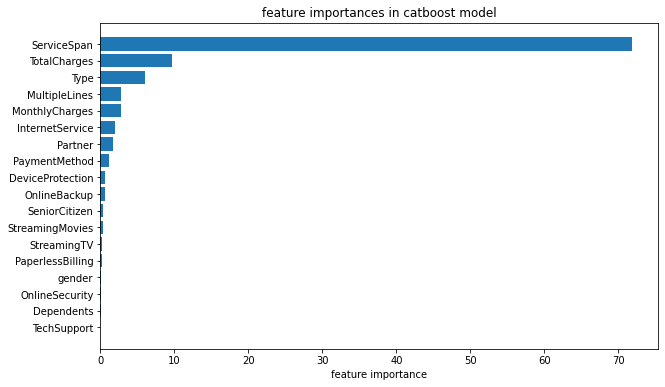

In [39]:
plt.figure(figsize=(10, 6))
plt.barh(aggregated_importances['orig_name'], aggregated_importances['importance'])
plt.xlabel('feature importance')
plt.title('feature importances in catboost model')
plt.show()


## Итог

Данные были объеденины с сохранением каждого клиента, заполнены пропуски, переведены типы данных, обработаны исключения, создана колонка "ServiceSpan" (Длина подписки на сегодня) - это количество дней между началом договора и его закрытием, если есть и датой выгрузки данных если не закрыт договор (1 февраля 2020г)

Лучшей моделью оказалась catboost, на тестовой выборке набрала 0.76 по метрике auc roc, у нее довольно низкий recall и высокий precision, то есть довольно плохо предсказывает клиентов, которые уходят, но хорошо предсказывает тех, кто не уходит  

Самой важной характеристекой в предсказании ухода клиента является длина подписки на сегодняшний день (порядка 60+%), далее на 2 и 3 месте по значимости характеристиками являются месячные и итоговые расходы (порядка 10+% каждый)


Портрет клиента-отточника выглядит примерно таким образом:  
-является клиентом уже от 500 до 1300 дней (что самое важное исходя из моделирования)  
-в месяц тратит обычно либо минимум (20) либо от 80 до 110  
-всего потратил до 3000  
-не является пенсионером  
-давно стал клиентом (до 2016 года) (скорее связано с характеристикой продолжительности контракта)